### **Imports**

In [11]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_selection import chi2
from sko.PSO import PSO
from sklearn.feature_selection import chi2
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import ttest_rel
from statistics import mean, stdev
import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

### **Data Ingestion**

In [ ]:
# Carregamento de Dados
test = pd.read_csv(r'../datasets/test_data_cleaned.csv')
train = pd.read_csv(r'../datasets/training_data_cleaned.csv')
train = train.drop(columns=['hour', 'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN'])
test = test.drop(columns=['hour', 'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN'])

### **Data Segregation**

In [13]:
y = train[['AVERAGE_SPEED_DIFF']]
X = train.drop(columns=['AVERAGE_SPEED_DIFF'])
X_test = test

### **Model Training**

### *Random Forest*

In [14]:
# 1. Separar um conjunto de validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=2025
)

# 2. Configurar o Pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=2025)),
    ('model', RandomForestClassifier(random_state=2025))
])

# 3. Definir a estratégia de CV, Stratified K-Fold
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=2025)

param_grid = {
    'model__n_estimators': [120],
    'model__max_depth': [16, 17, 18],
    'model__min_samples_split': [2, 3],
    'model__min_samples_leaf': [1, 2],
    'model__criterion': ['entropy'],
}

# 4. GridSearch com StratifiedKFold integrado
model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1_macro',
    n_jobs=-1
)

model.fit(X_train, y_train)

# 5. Resultados
print(f"Melhores parâmetros encontrados: {model.best_params_}")
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))   
print(accuracy_score(y_val, y_pred))

c:\Users\Luimp\anaconda3\envs\DAA\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Melhores parâmetros encontrados: {'model__criterion': 'entropy', 'model__max_depth': 18, 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 120}
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       431
           1       0.68      0.77      0.72       275
           2       0.83      0.78      0.81       357
           3       0.80      0.78      0.79       208
           4       0.85      0.79      0.82        92

    accuracy                           0.81      1363
   macro avg       0.81      0.80      0.81      1363
weighted avg       0.82      0.81      0.81      1363

0.8136463683052091


### **Feature Importance**

#### **FI based on Mean Decrease in Impurity (MDI) (Model Specific)**

In [15]:
start_time = time.time()

# Extract the best random forest model from the pipeline found by GridSearchCV
best_rf_model = model.best_estimator_.named_steps['model']

std = np.std([tree.feature_importances_ for tree in best_rf_model.estimators_], axis=0)

mdi_importances = pd.Series(best_rf_model.feature_importances_, index=X_test.columns) # 

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.016 seconds


Feature importances using MDI:
 AVERAGE_TIME_DIFF          0.399602
AVERAGE_FREE_FLOW_SPEED    0.098328
hour_cos                   0.088346
hour_sin                   0.071950
dayofweek                  0.047859
LUMINOSITY                 0.046010
AVERAGE_FREE_FLOW_TIME     0.045562
AVERAGE_TEMPERATURE        0.036660
dayofyear                  0.033780
week                       0.028605
AVERAGE_HUMIDITY           0.026712
AVERAGE_ATMOSP_PRESSURE    0.026252
AVERAGE_WIND_SPEED         0.024276
month                      0.019041
year                       0.007017
dtype: float64


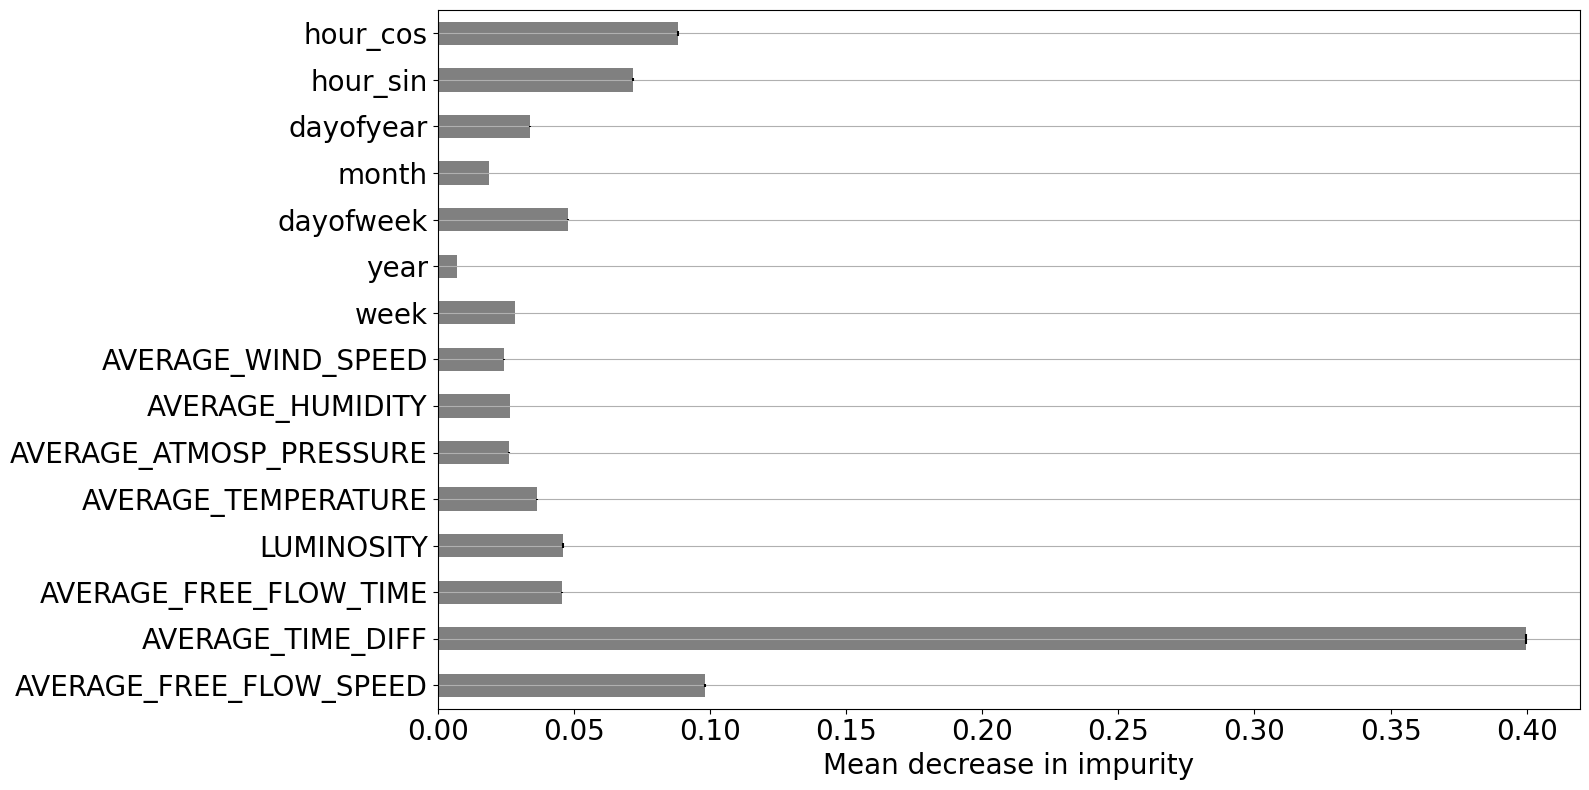

In [16]:
print("Feature importances using MDI:\n", mdi_importances.sort_values(ascending=False))
fig, ax = plt.subplots(figsize=(16,8))
mdi_importances.plot.barh(yerr=std,ax=ax, color='grey')
ax.grid(axis='y')
ax.set_xlabel("Mean decrease in impurity", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
fig.tight_layout()
plt.show()

#### **FI based on Permutation Importance (Model Agnostic)**

In [17]:
start_time = time.time()

result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 7.091 seconds


Feature importances using PI:
 AVERAGE_TIME_DIFF          0.517039
AVERAGE_FREE_FLOW_SPEED    0.059836
dayofweek                  0.028503
hour_cos                   0.024497
hour_sin                   0.020346
dayofyear                  0.009121
AVERAGE_FREE_FLOW_TIME     0.008723
AVERAGE_TEMPERATURE        0.007868
year                       0.007665
month                      0.005478
LUMINOSITY                 0.005161
week                       0.004438
AVERAGE_WIND_SPEED         0.003949
AVERAGE_ATMOSP_PRESSURE    0.002536
AVERAGE_HUMIDITY           0.001560
dtype: float64


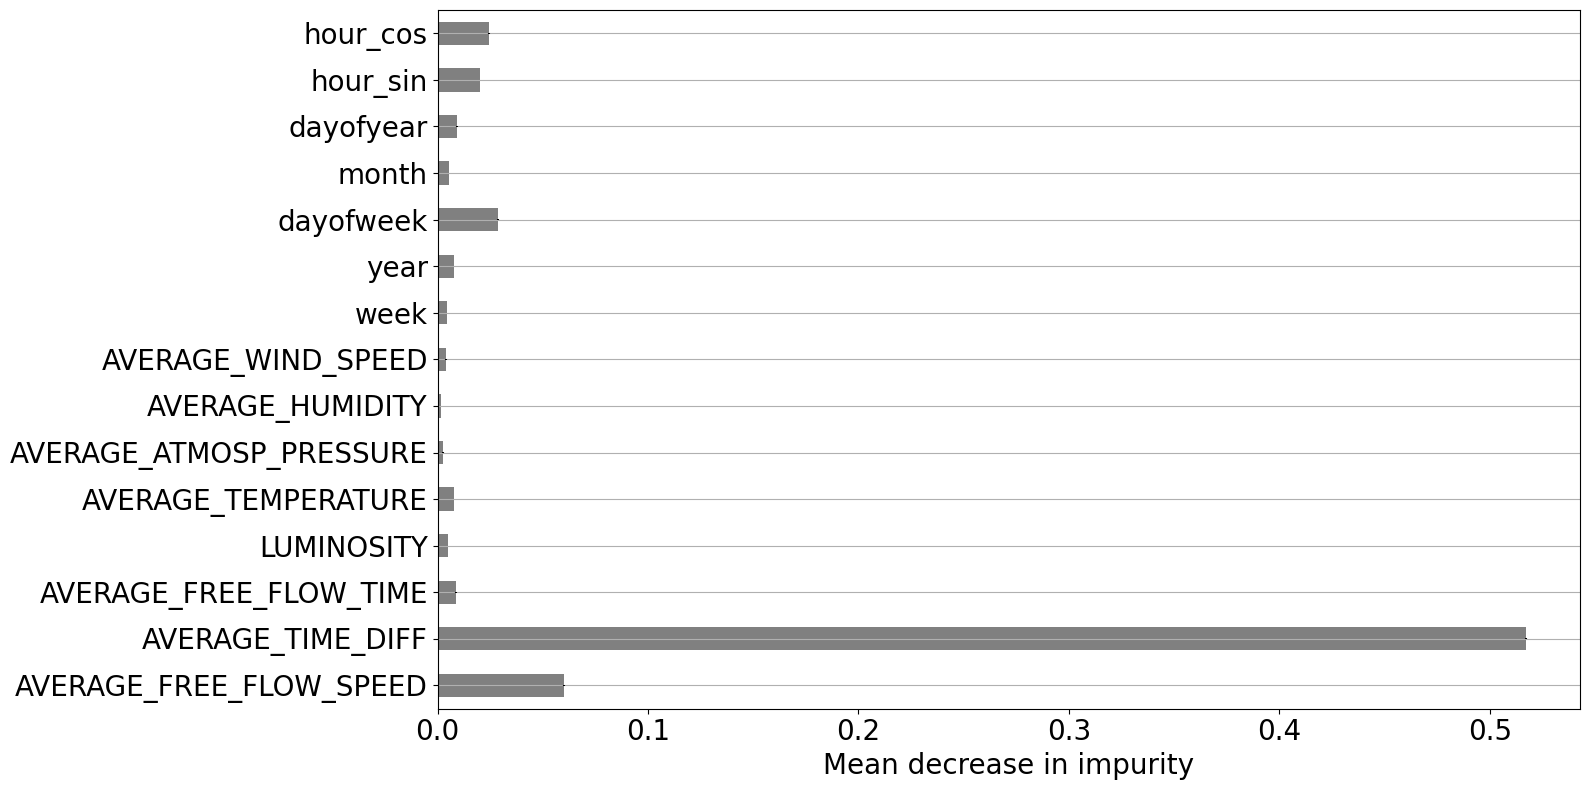

In [18]:
p_importances = pd.Series(result.importances_mean, index=X_val.columns)
print("Feature importances using PI:\n", p_importances.sort_values(ascending=False))
fig, ax = plt.subplots(figsize=(16,8))
p_importances.plot.barh(yerr=result.importances_std, ax=ax,color='grey')
ax.grid(axis='y')
ax.set_xlabel("Mean decrease in impurity", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
fig.tight_layout()
plt.show()

#### **Shap**

In [19]:
shap.initjs()

In [20]:
# Extract the actual classifier from the GridSearchCV pipeline
# The pipeline step is named 'model' as defined in Cell 8
tree_model = model.best_estimator_.named_steps['model']
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer(X_test)

##### **Local Interpretability**

Previsão de AVERAGE_SPEED_DIFF para esta amostra: 1 (Low)


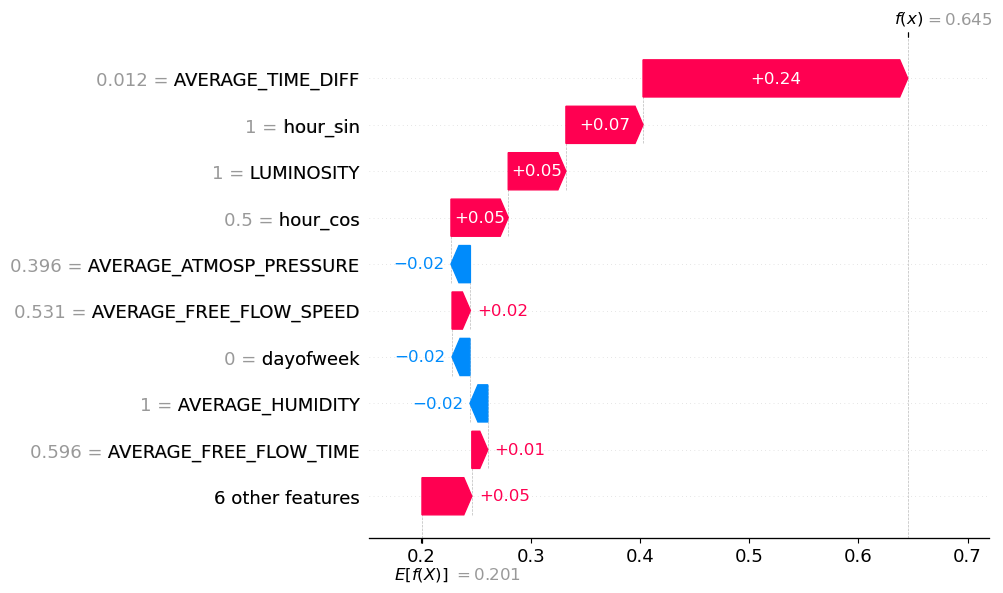

In [21]:
# 1. Escolher a linha (amostra) que quer analisar
no = 4

# 2. Fazer a previsão
# Usar .iloc[[no]] mantém o formato de DataFrame, o que ajuda o modelo a manter os nomes das colunas
prediction = model.predict(X_test.iloc[[no]])[0]
inverse_map = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
print(f"Previsão de AVERAGE_SPEED_DIFF para esta amostra: {prediction} ({inverse_map[prediction]})")

# 3. Plotar o Waterfall
# Para classificação multiclasse, precisamos especificar a classe
# shap_values[no] tem shape (12, 5) - precisamos escolher uma classe
# Vamos visualizar a classe predita
shap.plots.waterfall(shap_values[no, :, prediction])

##### **Global Interpretability**

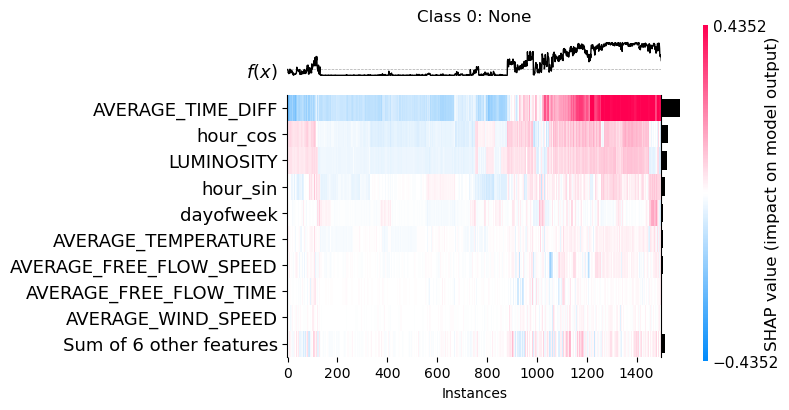

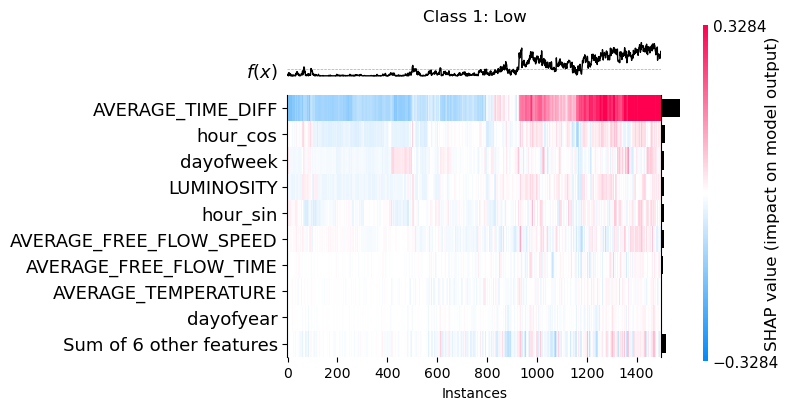

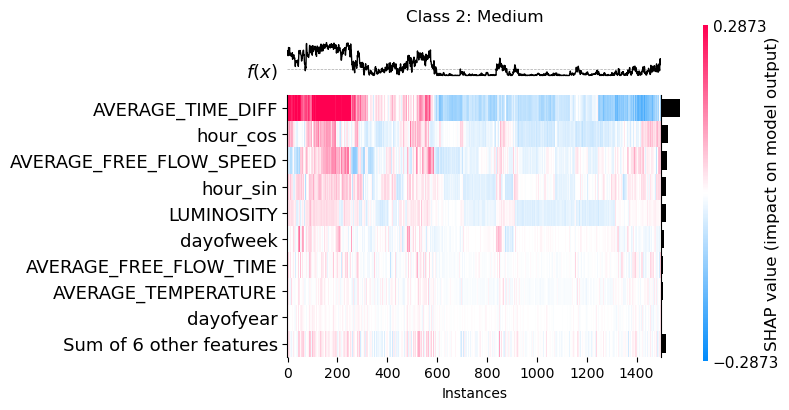

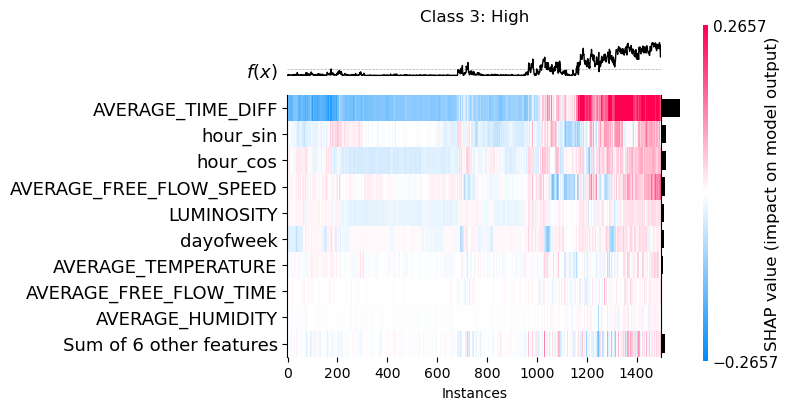

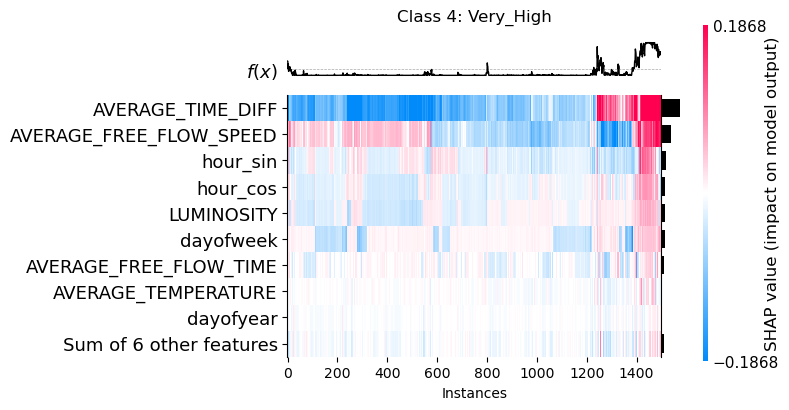

In [22]:
# For multiclass classification, visualize SHAP values for a specific class
# 0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'

shap.plots.heatmap(shap_values[:, :, 0], show=False)
plt.title("Class 0: None")
plt.tight_layout()
plt.show()

shap.plots.heatmap(shap_values[:, :, 1], show=False)
plt.title("Class 1: Low")
plt.tight_layout()
plt.show()

shap.plots.heatmap(shap_values[:, :, 2], show=False)
plt.title("Class 2: Medium")
plt.tight_layout()
plt.show()

shap.plots.heatmap(shap_values[:, :, 3], show=False)
plt.title("Class 3: High")
plt.tight_layout()
plt.show()

shap.plots.heatmap(shap_values[:, :, 4], show=False)
plt.title("Class 4: Very_High")
plt.tight_layout()
plt.show()

### **Submission Preparation**

In [23]:
# Exportar modelo treinado
import joblib
joblib.dump(model, 'RandomForest.pkl')

['RandomForest.pkl']

In [24]:
# Previsões no conjunto de teste
y_test = model.predict(X_test)

In [25]:
# Desmapeamento dos valores preditos para as categorias originais
inverse_map = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
y_test = pd.Series(y_test).map(inverse_map)

In [26]:
# Criar CSV de submissão
submission = pd.DataFrame({'RowId': range(1, len(X_test)+1), 'Speed_Diff': y_test})
submission.to_csv('submission.csv', index=False)